In [1]:
##편향되지 않는 모델 성능 측정하기
##머신 러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
##머신 러닝 모델 세부 튜닝하기
##여러 가지 성능 지표를 사용하여 모델의 예측 성능 평가하기

In [2]:
####파이프라인을 사용한 워크 플로####
##여러개의 변환 단계를 포함한 모델을 학습하고 새로운 데이터에 대한 예측 생성 가능

In [3]:
##훈련 세트와 테스트 세트로 분할하기

#유방암 데이터 불러오기
import pandas as pd

df = pd.read_csv(r'E:\Programming\python\ML\data\wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#30개의 특성을 넘파이 배열 X에 할당. LabelEncoder 객체를 사용하여 원본 문자열에서 정수로 변환
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
#악성(Benign)은 클래스 1로 표현, 양성(Malignant)는 클래스 0으로 표현된다
le.transform(['M','B'])

array([1, 0], dtype=int64)

In [6]:
#훈련세트 80%, 테스트 세트 20%로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [7]:
##PCA를 통해 30차원의 데이터를 2차원으로 낮추기
#StandardScaler, PCA, LogisticRegression을 하나의 파이프라인으로 연결
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))
pipe_lr.fit(X_train, y_train) #pipline에 묶여있는 모든 변환기의 fit과 transform 메서드를 차례로 거쳐 추정기 객체에 도달한다.
y_pred = pipe_lr.predict(X_test) #predict 메서드는 마지막 추정기 객체가 변환된 데이터의 예측을 반환한다.
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [8]:
##사이킷런 변환기 중 fit/transform 메서드를 지원하는 객체에 한에서 make_pipline 함수를 이용해 연결 가능하다.
#위의 pipline 예시를 분석해보면 우선적으로 StandardScaler의 fit과 transform 메서드를 거쳐 변환된 데이터를 PCA 객체로 전달되 저차원으로 변환한 후 LogisticRegression 모델이 변환된 데이터로 학습한다. 중간단계의 개수 제한은 없지만 중요한 점은 마지막 단계는 항상 추정기가 되어야한다는 점이다.

In [9]:
####홀드아웃 교차 검증####
#1. 초기 데이터셋을 별도의 훈련세트(모델 훈련용)와 테스트 세트(일반화 성능 추정용)로 나눈다
##모델선택(예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교하는 과정 중 최적의 파라미터를 선택한는 것)에서 테스트 세트를 계속 사용하면 과대 적합이 된다.
#2. 홀드 아웃에선 훈련세트를 다시 훈련세트(여러가지 모델 훈련), 검증 세트(최적의 파라미터가 나올때까지 반복적으로 모델 성능 평가), 그 후 기존에 사용하지 않은(모델 입장에선 처음 마주한) 테스트 세트를 통해 성능평가 실시
#단점: 훈련 데이터를 어떤 방법으로 검증과 훈련 데이터 세트로 나누느냐에 따라 성능 추정이 민감할 수 있음

In [10]:
####k-겹 교차 검증####
#중복을 허락하지 X => 검증에 한 번만 사용되는 장점
#1. 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눔
#2. k-1개의 폴드로 모델을 훈련하고 남은 한 개로 모델을 평가
#3. 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다
#4. 독립적인 모델들의 평균 성능을 계산
##주로 최적의 파라미터를 찾기 위해 사용
#5. 최적의 파라미터를 찾은 후엔 전체 훈련 세트를 사용하여 모델을 다시 훈련한다(전체 훈련 세트를 사용하는 이유는 훈련 세트가 클수록 알고리즘이 더 정확하고 안정적이기 때문)
#6. 독립적인 테스트 세트를 사용해서 최종 성능을 추정한다


In [11]:
####계층적 k-겹 교차 검증####
##클래스 비율이 동등하지 않을때 좀 더 나은 편향과 분산 추정을 만든다

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, #훈련세트의 y_train 클래스 레이블을 전달해서 초기화 / n_splits로 폴드 개수 지정
                        random_state=1).split(X_train, y_train) 
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [13]:
#계층별 k-겹 교차 검증 사용
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1) #하나의 cpu코어만 성능평가에 참여 (2로 설정하면 두개의 코어에 교차검증을 10회씩 분산/-1은 설치된 모든 코어에 병렬처리)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


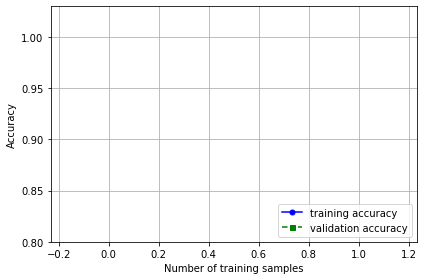

In [14]:
##학습 곡선 함수를 통한 모델 평가##
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear',
                                           penalty='12',
                                           random_state=1))
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10), #일정한 간격으로 훈련세트 비율 열개를 검증
                               cv=10, #k겹 교차의 k 값이 10을 뜻함
                               n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

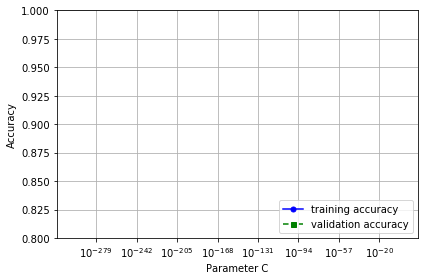

In [15]:
###검증 곡선으로 과대적합과 과소적합 조사###
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green',linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()